In [7]:
from unet import unet_constructor as GUnet
import dataloader as dataloader
from loss import dice_loss, cross_entropy_loss, random_cross_entropy
import transforms as t
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as tt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import skimage.io as io
import os

writer = SummaryWriter()

In [8]:
data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.nul_crop(rate=.8),
                                          t.random_crop([300, 300, 30]),
                                          t.random_rotate(),
                                          t.random_affine()
                                          ],
                        image_transforms=[
                                          t.drop_channel(1), 
                                          t.random_gamma((.8,1.2)),
                                          t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )

val_data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.random_crop([512, 512, 30]),
                                          t.random_rotate(90),
                                          #t.random_affine
                                          ],
                        image_transforms=[
                                          #t.random_gamma((.8,1.2)),
                                          #t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )



In [9]:
device = 'cuda:0'

test = GUnet(image_dimensions=3,
             in_channels=4,
             out_channels=1,
             feature_sizes=[16,32,64,128],
             kernel={'conv1': (3, 3, 2), 'conv2': (3, 3, 1)},
             upsample_kernel=(8, 8, 2),
             max_pool_kernel=(2, 2, 1),
             upsample_stride=(2, 2, 1),
             dilation=1,
             groups=2).to(device)


test = test.type(torch.float)

image, mask, pwl = data[0]

out = test.forward(image.float().to(device))
out_loss = dice_loss(out, mask.to(device))#, pwl.float().to('cuda'))



In [10]:
test.load('May5_chris-MS-7C37_3.unet')
test.cuda()
test.train()
print('Yeet')

Yeet


In [11]:
epoch = 0 
k = 0
running_loss = 0
device = 'cuda:0'

losses_dice=[]
avg_losses_dice = []
losses_BCE=[]
avg_losses_BCE = []



In [12]:
lr = .01
gamma = .75

optimizer = torch.optim.Adam(test.parameters(), lr = lr)
#optimizer = torch.optim.SGD(test.parameters(), lr=lr, momentum=.99, nesterov=True)

scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)


In [ ]:
while True:  # loop over the dataset multiple times
    epoch_loss_dice=[]
    epoch_loss_BCE=[]
    epoch_loss_joint=[]
    for i in range(len(data)):
        image, mask, pwl  = data[i]

        optimizer.zero_grad()
        out = test(image.float().to('cuda'))


        out_loss = ((np.cos(2*np.pi * (epoch/100))+1)/4 + .2) * cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda'), 5) +\
                   dice_loss(out, mask.to('cuda'))
        epoch_loss_joint.append(out_loss.item())
        
        print(f'\r\033[32mEpoch: \033[0m{epoch} |',end='')
        print(f' JOINT |', end='')
        print(f' {i} |',end='')
        print(f' \033[35mPOL: \033[0m{str(running_loss)[0:8]} -->', end='')
        print(f' \033[35mOL: \033[0m{str(out_loss.item())[0:8]}', end='')

        out_loss.backward()
        optimizer.step()

        running_loss = out_loss.item()

        if epoch+1 % 150 == 0:
            scheduler_1.step() 

    
    to_tb = np.array(epoch_loss_joint).sum()/len(epoch_loss_joint)
    writer.add_scalar('Cyclic Joint Loss Train', to_tb, epoch)
    epoch += 1




Epoch: 80 | JOINT | 0 | POL: 0.311593 --> OL: 0.427873

In [ ]:
test.save('May5_chris-MS-7C37_4.unet')

In [14]:
image, mask, pwl  = val_data[8]
test.eval()
#test.cpu()
with torch.no_grad(): 
    out = test(image.float().cuda())


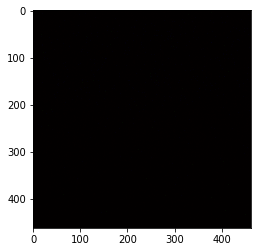

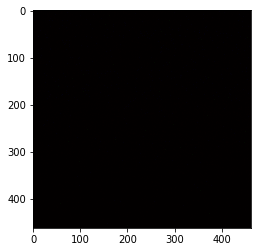

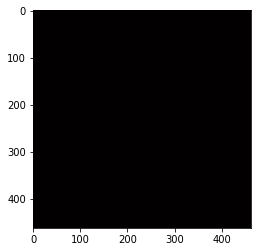

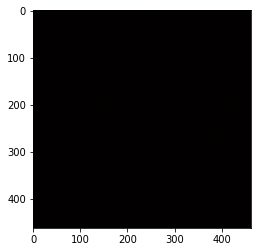

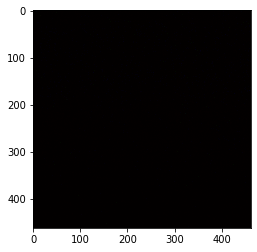

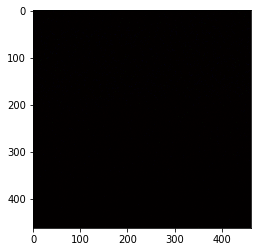

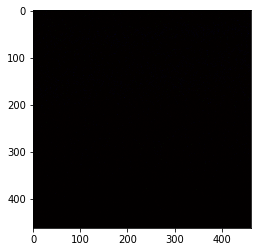

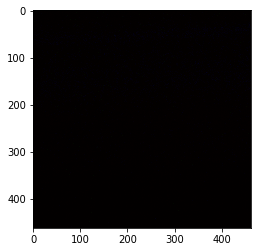

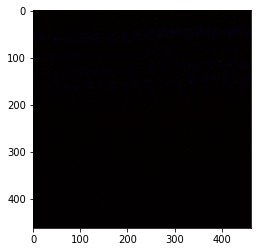

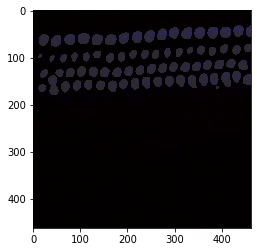

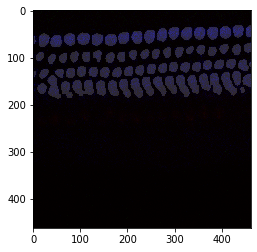

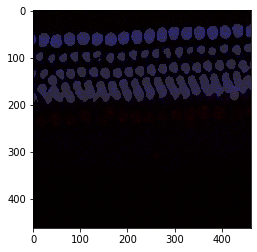

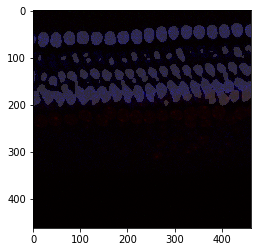

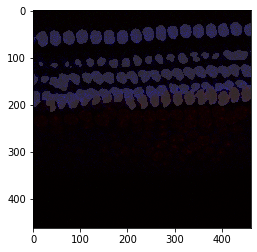

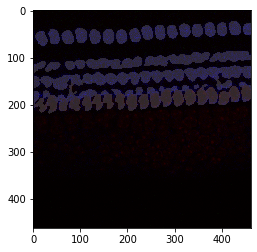

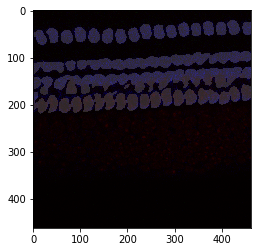

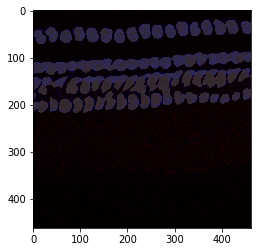

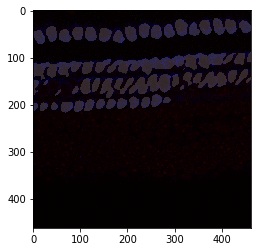

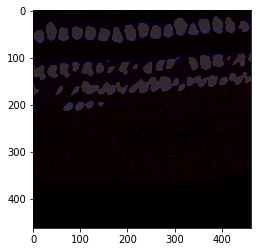

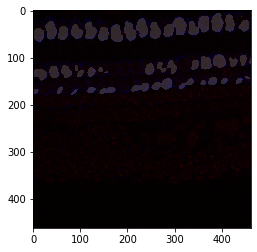

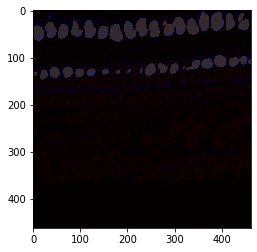

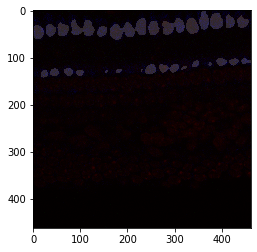

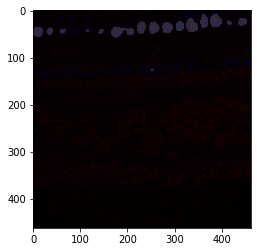

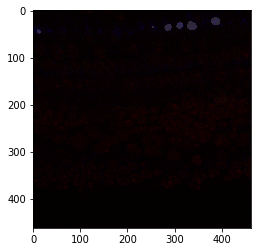

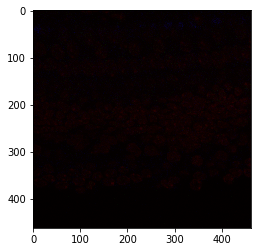

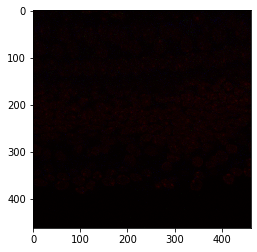

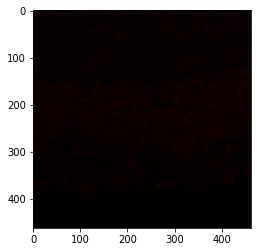

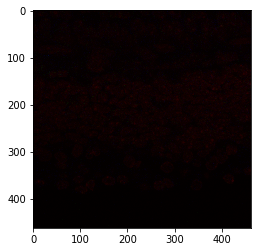

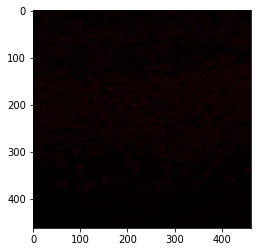

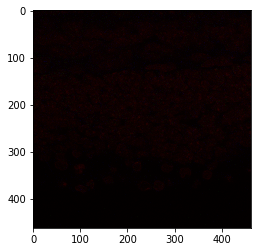

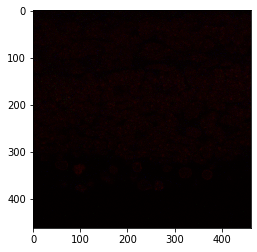

IndexError: index 31 is out of bounds for dimension 4 with size 31

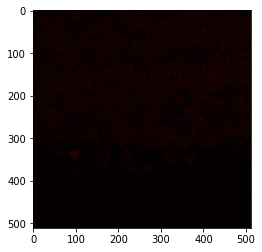

In [21]:
pred = F.sigmoid(out) > .5
for i in range(image.shape[-1]):
    #plt.imshow(image[0,0:3,:,:,i].transpose(0,1).transpose(1,2)*.5 + .5)
    plt.imshow(image[0,0:3,:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    #plt.imshow(mask[0,0,:,:,i].float(), cmap = 'Greens')
    plt.imshow(pred[0,0,:,:,i].cpu().detach().numpy(), cmap=plt.cm.nipy_spectral,alpha=.2)
    plt.show()


In [19]:
pred.shape

torch.Size([1, 1, 462, 462, 31])

In [ ]:
io.imsave('overlap.tif', pred.cpu().squeeze(0).transpose(0,3).float().numpy())

In [ ]:
n.shape

In [ ]:
image.float()